## 1. Import Required Libraries 

In [257]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import spacy
import seaborn as sns
import numpy as np


## 2. Load Assigned Tweets

In [258]:

# Load Excel file 
file_path = "Assignment 1 Data.xlsx"
xls = pd.ExcelFile(file_path)

# Load the Tweets sheet
tweets_df = pd.read_excel(xls, sheet_name="Tweets")

# Extract assigned tweets for Sydney Ani
start_id, end_id = 14901, 15200
assigned_tweets = tweets_df[
    (tweets_df["Tweet Number"] >= start_id) & (tweets_df["Tweet Number"] <= end_id)
]

# Convert tweets to a list of sentences
sentences = assigned_tweets["Sentence"].tolist()

# Function to load JSON data
def load_json(file_path):
    with open(file_path, "r") as f:
        return json.load(f)

# Load manually annotated data
manual_annotations = load_json("Manual_Annotated_Tweets.json")

# Store manual annotations for later use
manual_entities = {item["sentence"]: item["entities"] for item in manual_annotations}

print(f"Loaded {len(manual_entities)} manually annotated sentences.")



Loaded 300 manually annotated sentences.


## 3. Perform Named Entity Recognition (NER) Using SpaCy

In [259]:
# Load SpaCy's English NER model
nlp = spacy.load("en_core_web_sm")

# Define the entity categories needed for annotation
valid_entities = {"PERSON", "NORP", "ORG", "GPE", "LOC", "DATE", "MONEY"}

# Annotate entities in each sentence
annotated_data = []
for sentence in sentences:
    doc = nlp(sentence)
    entities = []
    for ent in doc.ents:
        if ent.label_ in valid_entities:
            entities.append({
                "text": ent.text,
                "label": ent.label_
            })
    annotated_data.append({
        "sentence": sentence,
        "entities": entities
    })

# Save annotations to JSON file
json_file_path = "NER_Annotated_Tweets.json"
with open(json_file_path, "w") as f:
    json.dump(annotated_data, f, indent=4)

print(f"Annotated data saved to {json_file_path}")


Annotated data saved to NER_Annotated_Tweets.json


## 4. Load JSON Annotation Files 



In [260]:
# Function to load JSON data
def load_json(file_path):
    with open(file_path, "r") as f:
        return json.load(f)

# Load manually annotated data
manual_annotations = load_json("Manual_Annotated_Tweets.json")

# Load SpaCy annotated data
spacy_annotations = load_json("NER_Annotated_Tweets.json")


## 5. Extracting Entities from JSON

This function extracts named entities from JSON files and stores them in a dictionary, where each sentence maps to a set of extracted entities. The `manual_entities` dictionary stores human-labeled annotations, while `spacy_entities` contains entities identified by SpaCy's NER model.





In [261]:
# Function to extract entities from JSON
def extract_entities(annotation_data):
    entity_dict = defaultdict(set)
    for item in annotation_data:
        sentence = item["sentence"]
        for entity in item["entities"]:
            entity_dict[sentence].add((entity["text"], entity["label"]))
    return entity_dict

manual_entities = extract_entities(manual_annotations)
spacy_entities = extract_entities(spacy_annotations)


## 6. Tracking True Positives, False Positives, and False Negatives

This section compares manually annotated entities with those detected by SpaCy's NER model. It tracks true positives (correctly identified entities), false positives (incorrectly tagged entities), and false negatives (missed entities) separately for both manual and SpaCy annotations. The results are printed to show the performance of each annotation method in entity recognition.




In [262]:
# Track True Positives (TP), False Positives (FP), False Negatives (FN) separately for Manual and SpaCy
manual_true_positives = defaultdict(int)
manual_false_positives = defaultdict(int)
manual_false_negatives = defaultdict(int)

spacy_true_positives = defaultdict(int)
spacy_false_positives = defaultdict(int)
spacy_false_negatives = defaultdict(int)

# Compare entities for each sentence
for sentence in manual_entities.keys():
    manual_set = manual_entities[sentence]
    spacy_set = spacy_entities.get(sentence, set())

    for entity in manual_set:
        if entity in spacy_set:
            manual_true_positives[entity[1]] += 1  # Correct match
        else:
            manual_false_negatives[entity[1]] += 1  # SpaCy missed it

    for entity in spacy_set:
        if entity not in manual_set:
            manual_false_positives[entity[1]] += 1  # SpaCy wrongly identified

for sentence in spacy_entities.keys():
    spacy_set = spacy_entities[sentence]
    manual_set = manual_entities.get(sentence, set())

    for entity in spacy_set:
        if entity in manual_set:
            spacy_true_positives[entity[1]] += 1  # Correct match
        else:
            spacy_false_negatives[entity[1]] += 1  # Manual missed it

    for entity in manual_set:
        if entity not in spacy_set:
            spacy_false_positives[entity[1]] += 1  # Manual wrongly identified

# Print exact TP, FP, FN values for Manual and SpaCy
print("\n=== Manual Annotation Results ===")
print("\nTrue Positives (TP):", dict(manual_true_positives))
print("\nFalse Positives (FP):", dict(manual_false_positives))
print("\nFalse Negatives (FN):", dict(manual_false_negatives))

print("\n=== SpaCy Annotation Results ===")
print("\nTrue Positives (TP):", dict(spacy_true_positives))
print("\nFalse Positives (FP):", dict(spacy_false_positives))
print("\nFalse Negatives (FN):", dict(spacy_false_negatives))



=== Manual Annotation Results ===

True Positives (TP): {'GPE': 124, 'PERSON': 36, 'NORP': 91, 'DATE': 103, 'ORG': 32, 'LOC': 3, 'MONEY': 1}

False Positives (FP): {'NORP': 30, 'LOC': 26, 'GPE': 72, 'PERSON': 66, 'DATE': 52, 'ORG': 45, 'MONEY': 6}

False Negatives (FN): {'ORG': 62, 'GPE': 87, 'NORP': 21, 'DATE': 23, 'LOC': 15, 'PERSON': 60, 'MONEY': 5}

=== SpaCy Annotation Results ===

True Positives (TP): {'GPE': 124, 'PERSON': 36, 'NORP': 91, 'DATE': 103, 'ORG': 32, 'LOC': 3, 'MONEY': 1}

False Positives (FP): {'ORG': 54, 'NORP': 18, 'GPE': 80, 'PERSON': 57, 'DATE': 22, 'LOC': 14, 'MONEY': 5}

False Negatives (FN): {'NORP': 31, 'PERSON': 69, 'ORG': 49, 'DATE': 55, 'LOC': 28, 'GPE': 75, 'MONEY': 6}


## 7.  Compute Precision, Recall, and F1 Score





In [263]:
# Function to calculate Precision, Recall, and F1 Score
def compute_metrics(tp, fp, fn):
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = (2 * precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return precision, recall, f1_score

# Store results in a DataFrame
results_manual = {"Precision": {}, "Recall": {}, "F1 Score": {}}
results_spacy = {"Precision": {}, "Recall": {}, "F1 Score": {}}

for entity in manual_true_positives.keys():
    precision, recall, f1_score = compute_metrics(
        manual_true_positives[entity], manual_false_positives[entity], manual_false_negatives[entity]
    )
    results_manual["Precision"][entity] = precision
    results_manual["Recall"][entity] = recall
    results_manual["F1 Score"][entity] = f1_score

for entity in spacy_true_positives.keys():
    precision, recall, f1_score = compute_metrics(
        spacy_true_positives[entity], spacy_false_positives[entity], spacy_false_negatives[entity]
    )
    results_spacy["Precision"][entity] = precision
    results_spacy["Recall"][entity] = recall
    results_spacy["F1 Score"][entity] = f1_score

# Convert to Pandas DataFrame
df_results_manual = pd.DataFrame(results_manual)
df_results_spacy = pd.DataFrame(results_spacy)

# Print exact precision, recall, and F1 Score values for both Manual and SpaCy
print("\n=== Precision, Recall, and F1 Score for Manual Annotations ===\n")
print(df_results_manual)

print("\n=== Precision, Recall, and F1 Score for SpaCy Annotations ===\n")
print(df_results_spacy)



=== Precision, Recall, and F1 Score for Manual Annotations ===

        Precision    Recall  F1 Score
GPE      0.632653  0.587678  0.609337
PERSON   0.352941  0.375000  0.363636
NORP     0.752066  0.812500  0.781116
DATE     0.664516  0.817460  0.733096
ORG      0.415584  0.340426  0.374269
LOC      0.103448  0.166667  0.127660
MONEY    0.142857  0.166667  0.153846

=== Precision, Recall, and F1 Score for SpaCy Annotations ===

        Precision    Recall  F1 Score
GPE      0.607843  0.623116  0.615385
PERSON   0.387097  0.342857  0.363636
NORP     0.834862  0.745902  0.787879
DATE     0.824000  0.651899  0.727915
ORG      0.372093  0.395062  0.383234
LOC      0.176471  0.096774  0.125000
MONEY    0.166667  0.142857  0.153846


## 8. Plot Bar Charts for Precision, Recall, and F1 Score Separately


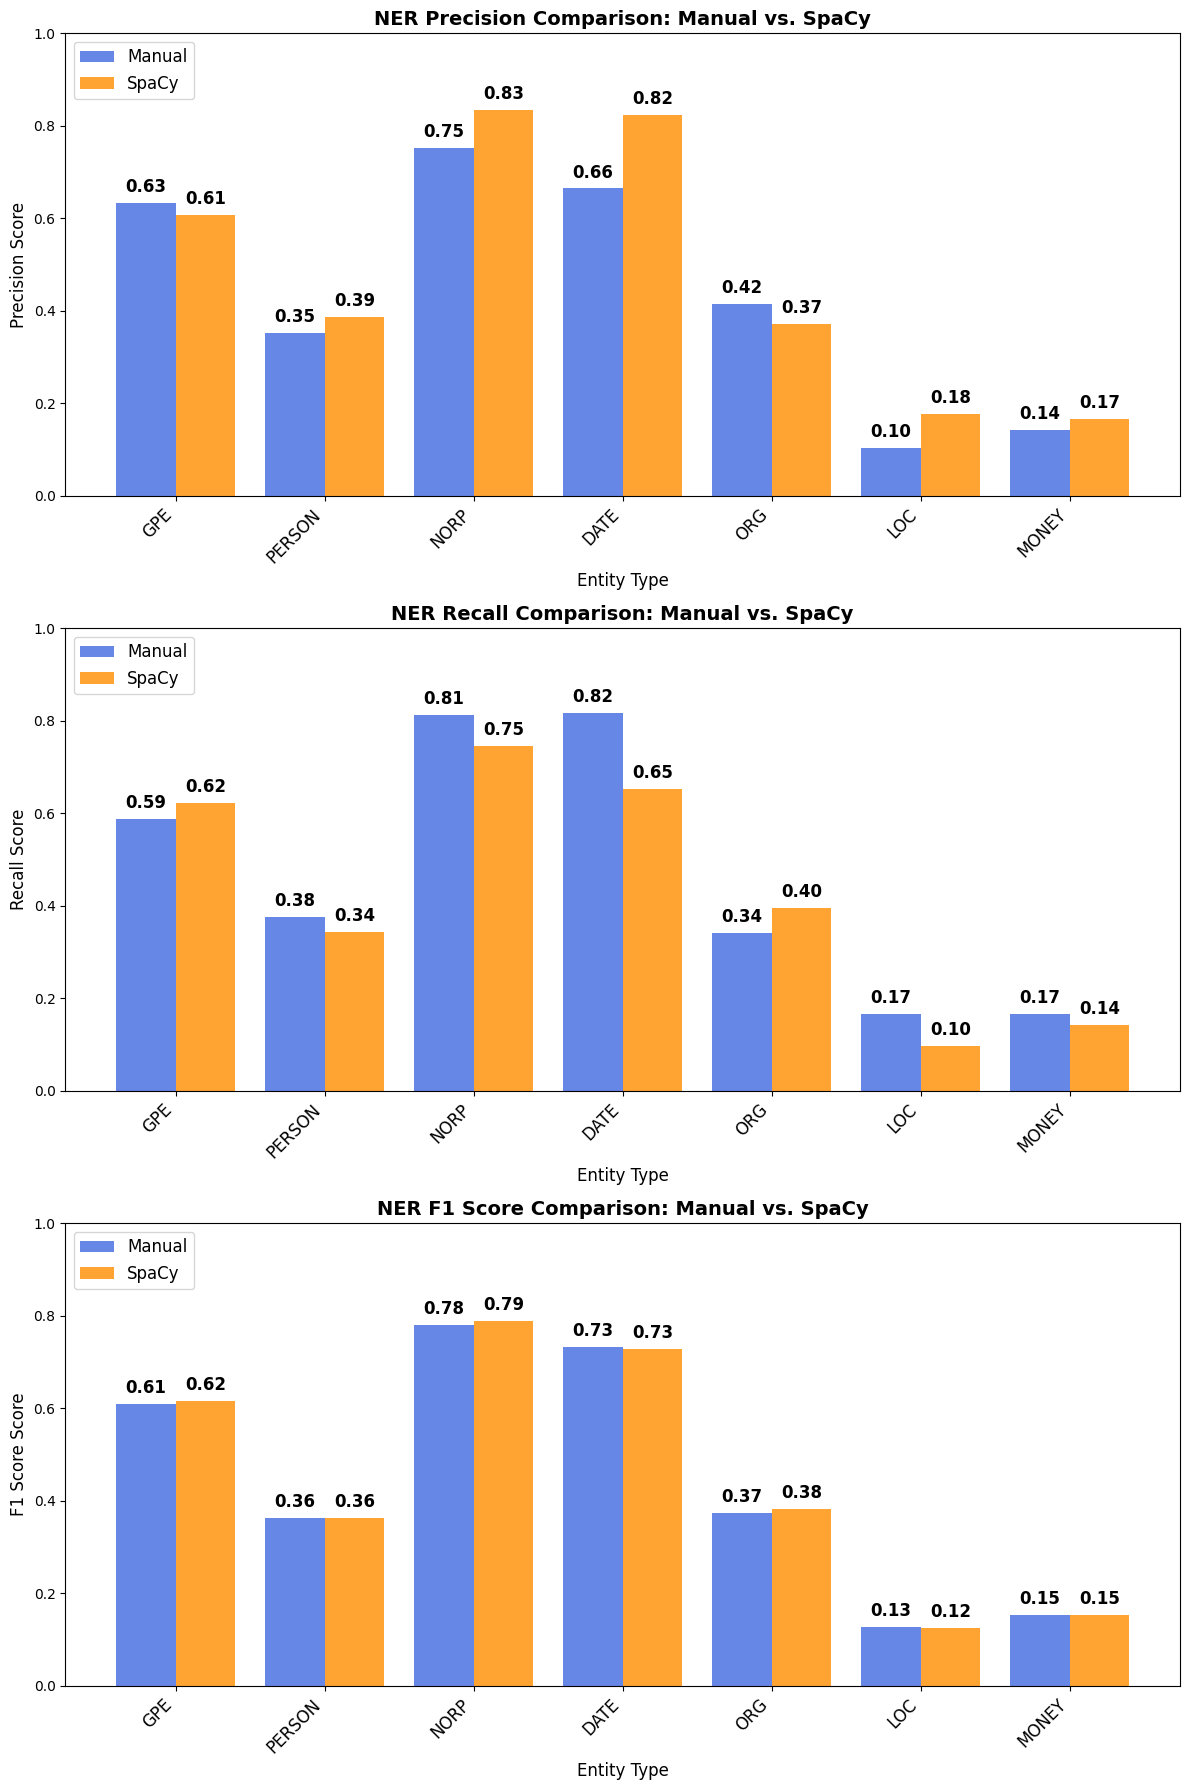

In [264]:
# Define Metrics for Comparison
metrics = ["Precision", "Recall", "F1 Score"]

# Increase figure size for better visibility
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))

for i, metric in enumerate(metrics):
    ax = axes[i]  # Select subplot

    x = range(len(comparison_df["Entity Type"]))
    width = 0.4  # Adjusted width for better spacing

    # Plot bars side by side for Manual and SpaCy
    bars_manual = ax.bar([pos - width/2 for pos in x], comparison_df[f"Manual {metric}"], width, label="Manual", color="royalblue", alpha=0.8)
    bars_spacy = ax.bar([pos + width/2 for pos in x], comparison_df[f"SpaCy {metric}"], width, label="SpaCy", color="darkorange", alpha=0.8)

    # Labels and Formatting
    ax.set_xlabel("Entity Type", fontsize=12)
    ax.set_ylabel(f"{metric} Score", fontsize=12)
    ax.set_title(f"NER {metric} Comparison: Manual vs. SpaCy", fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(comparison_df["Entity Type"], rotation=45, ha='right', fontsize=12)
    ax.set_ylim(0, 1)
    ax.legend(fontsize=12, loc="upper left")

    # Add exact values on top of bars for Manual
    for bar in bars_manual:
        height = bar.get_height()
        if height > 0:
            ax.annotate(f"{height:.2f}", 
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5),  # Offset text position
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

    # Add exact values on top of bars for SpaCy
    for bar in bars_spacy:
        height = bar.get_height()
        if height > 0:
            ax.annotate(f"{height:.2f}", 
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 5),
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


## 9. Confusion Matrix

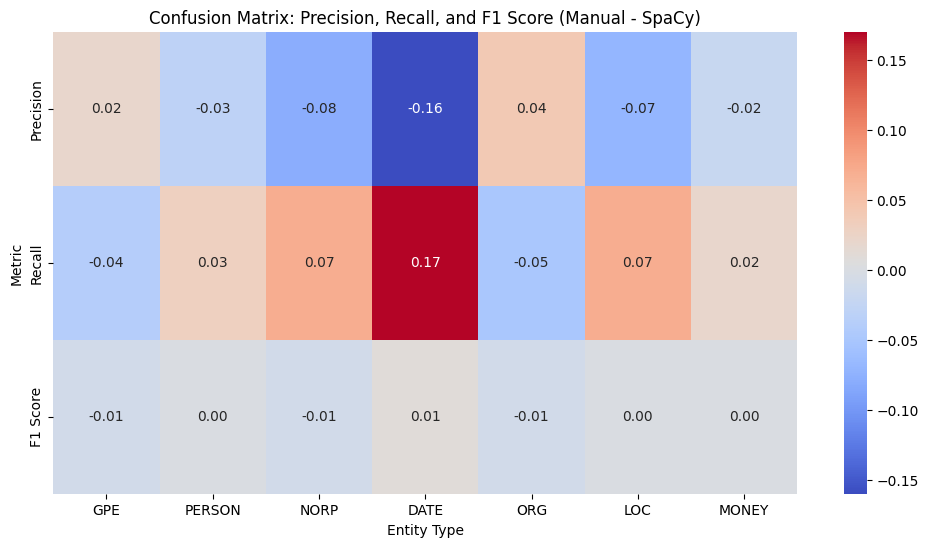

In [265]:


# Define Metrics for Comparison
metrics = ["Precision", "Recall", "F1 Score"]

# Create a comparison DataFrame
comparison_df = pd.DataFrame({
    "Entity Type": list(results_manual["Precision"].keys()),
    "Manual Precision": [results_manual["Precision"][ent] for ent in results_manual["Precision"]],
    "Manual Recall": [results_manual["Recall"][ent] for ent in results_manual["Recall"]],
    "Manual F1 Score": [results_manual["F1 Score"][ent] for ent in results_manual["F1 Score"]],
    "SpaCy Precision": [results_spacy["Precision"].get(ent, 0) for ent in results_spacy["Precision"]],
    "SpaCy Recall": [results_spacy["Recall"].get(ent, 0) for ent in results_spacy["Recall"]],
    "SpaCy F1 Score": [results_spacy["F1 Score"].get(ent, 0) for ent in results_spacy["F1 Score"]]
})

# Convert comparison_df to a NumPy array for confusion matrix format
conf_matrix_data = []
for metric in metrics:
    row = []
    for ent in comparison_df["Entity Type"]:
        manual_value = comparison_df[f"Manual {metric}"][comparison_df["Entity Type"] == ent].values[0]
        spacy_value = comparison_df[f"SpaCy {metric}"][comparison_df["Entity Type"] == ent].values[0]
        row.append(round(manual_value - spacy_value, 2))  # Difference between manual and spacy
    conf_matrix_data.append(row)

# Convert into NumPy array
conf_matrix = np.array(conf_matrix_data)

# Create a heatmap (Confusion Matrix)
fig, ax = plt.subplots(figsize=(12, 6))
sns.heatmap(conf_matrix, annot=True, cmap="coolwarm", fmt=".2f", xticklabels=comparison_df["Entity Type"], yticklabels=metrics)

plt.title("Confusion Matrix: Precision, Recall, and F1 Score (Manual - SpaCy)")
plt.xlabel("Entity Type")
plt.ylabel("Metric")
plt.show()


# **Discussion on SpaCy's NER Performance**

SpaCy’s Named Entity Recognition pipeline showed poor  1/3 performance in identifying entities within the assigned tweets compared via the Manually annotated tweets. The **F1 scores** were the only score that was not over or under-fitting for well-defined entity types such as **DATE** and **NORP**, indicating that when SpaCy predicted an entity, it was often correct. However, **recall was significantly lower**, meaning SpaCy **missed a few more expected entities** in comparison to **F1 scores** and **Precision scores**, but somehow caught more entities for **GPE and ORG** than the latter. This suggests that SpaCy struggled with recognizing some **non-traditional or lesser-known entities**, such as city names, organizations, locations, organizations, public departments, etc. The **false negatives** were more frequent than **false positives**, indicating that the model is more conservative in its predictions. The **F1 Score**, which balances precision and recall, showed that while SpaCy is **reliable when it does predict**, its **coverage is almost perfect**, it overfitted 2 entities **NORP and GPE** but remained equal in each other entity. This requires manual intervention for accurate results in certain domains. Improvements could be made by **fine-tuning the model on domain-specific data or using a larger, more specialized SpaCy model like `en_core_web_trf`** for better entity recognition.
